# Introduction

L'un des principaux problèmes des systèmes de location en libre-service est de toujours pouvoir subvenir aux besoins des clients alors que la demande fluctue constamment.  
Dans notre cas nous allons déterminer les facteurs influençant le nombre de location de vélo dans une ville et construire un algorithme prédisant la demande de vélo en fonction de données temporelles et météorologiques.

### Importation de la base

In [1]:
import pandas as pd 
import seaborn as sns
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgbm


from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV

### Importation de la base

In [2]:
data = pd.read_csv("hour.csv")
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Statistique Descritptive

Avant toute chose il est nécessaire de regarder s'il existe des données manquantes dans notre base. Il n'y a pas de données manquantes dans la base.  
Nous allons créer une nouvelle variable appelée week à partir de dtday.

In [3]:
##########
## Fonction permettant de calculer le pourcentage de données manquantes dans une table
##########

def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['Variable',"Valeurs Manquantes"]
    statitics['Nombre de lignes'] = df.shape[0]
    statitics['% Manquant'] = round((statitics['Valeurs Manquantes']/statitics['Nombre de lignes'])*100,2)
    return statitics

missing_statistics(data)

,Variable,Valeurs Manquantes,Nombre de lignes,% Manquant
0,instant,0,17379,0.0
1,dteday,0,17379,0.0
2,season,0,17379,0.0
3,yr,0,17379,0.0
4,mnth,0,17379,0.0
5,hr,0,17379,0.0
6,holiday,0,17379,0.0
7,weekday,0,17379,0.0
8,workingday,0,17379,0.0
9,weathersit,0,17379,0.0


In [4]:
##########
## Transformation de dtday en type datetime
## Création d'une nouvelle variable semaine
##########



data["dteday"]=pd.to_datetime(data["dteday"])
data["week"]=data["dteday"].dt.week

En calculant la matrice de corrélation nous obtenons des corrélations entre :
- casual/registered/cnt : c'est une relation logique étant donné que cnt = casual+registered
- temp/atemp : encore une relation logique
- temp/atemp/casual/registered/cnt : une corrélation positive entre ces variables ce qui nous indique que la température influe sur le nombre d'utilisateurs du service. La température influence surtout le nombre d'utilisateurs occasionnels
- hum/casual/registered/cnt : une corrélation négative. L'humidité influence principalement le nombre d'utilisateurs occasionnels

In [5]:
##########
## Matrice de corrélation
##########


corr= data[['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1,0.99,-0.07,-0.023,0.46,0.34,0.4
atemp,0.99,1,-0.052,-0.062,0.45,0.33,0.4
hum,-0.07,-0.052,1,-0.29,-0.35,-0.27,-0.32
windspeed,-0.023,-0.062,-0.29,1,0.09,0.082,0.093
casual,0.46,0.45,-0.35,0.09,1,0.51,0.69
registered,0.34,0.33,-0.27,0.082,0.51,1,0.97
cnt,0.4,0.4,-0.32,0.093,0.69,0.97,1


En regardant le boxplot de la variable cnt, notre variable possède une distribution asymétrique avec une forte asymétrie à gauche et un assez grand nombre d'outliers.

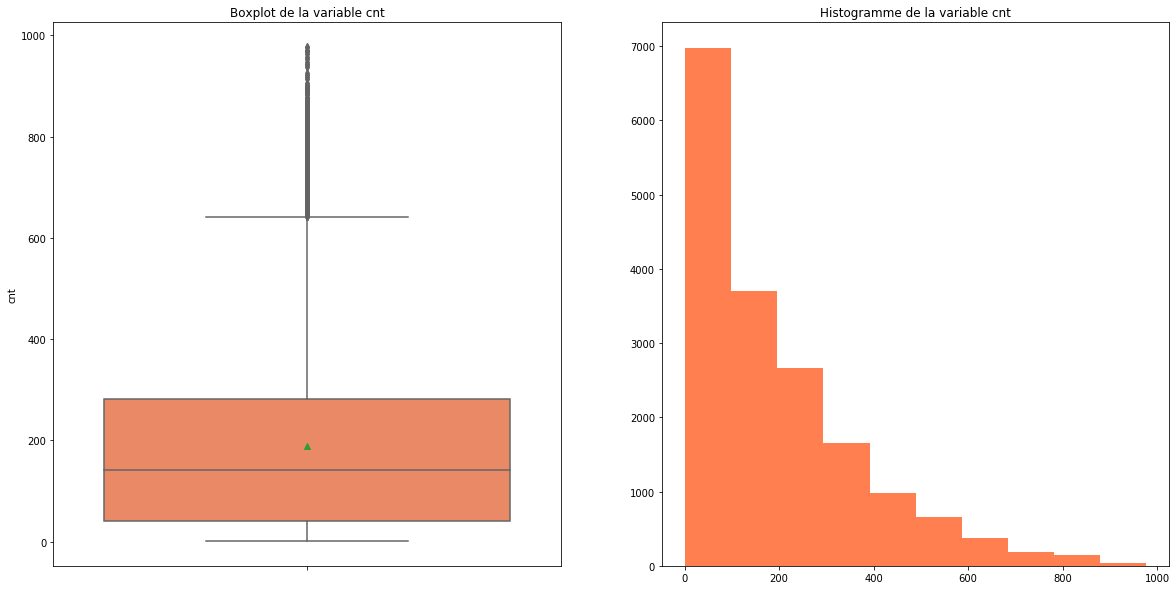

In [6]:
##########
## Histogramme et boxplot de la variable cnt
##########

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.boxplot(y=data["cnt"],showmeans=True,color='coral');
plt.title("Boxplot de la variable cnt")
plt.subplot(1, 2, 2)
plt.hist(x=data["cnt"],color='coral');
plt.title("Histogramme de la variable cnt")
plt.show()

Avec les boxplots de la variable cnt en fonction de la saison, nous observons qu'il y a moins de demande en hiver que pour les autres saisons et que la saison avec le plus de demandes semble être l'été suivi de très près par le printemps.

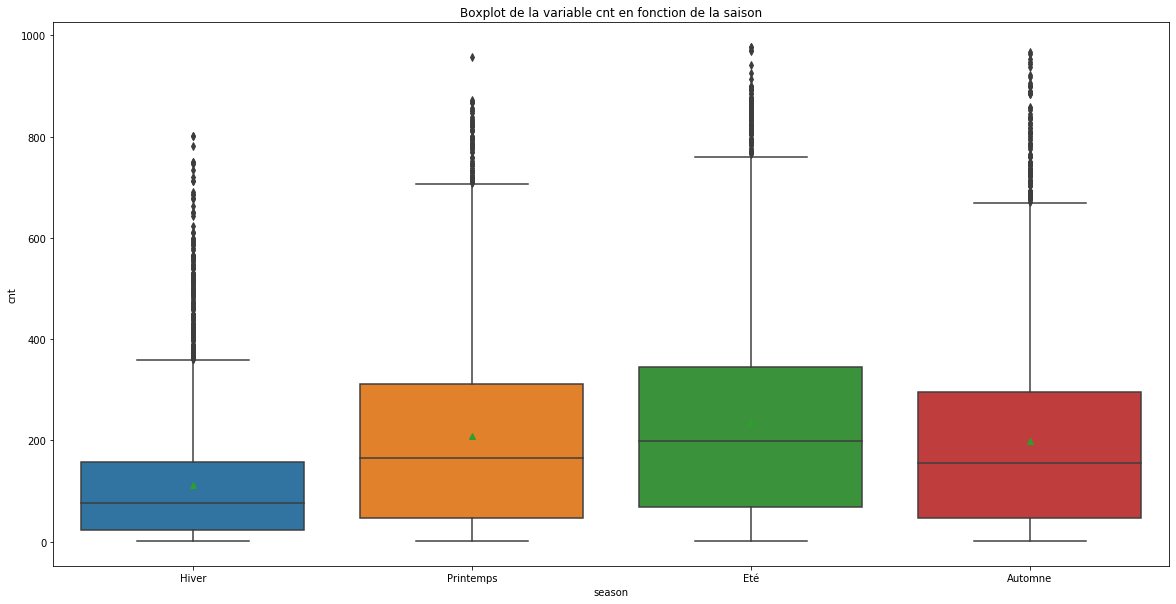

In [7]:
##########
## Boxplot de la variable cnt en fonction de la saison
##########


plt.figure(figsize=(20,10))
sns.boxplot(x=data['season'],y=data["cnt"],showmeans=True);
plt.title("Boxplot de la variable cnt en fonction de la saison")
plt.xticks([0, 1, 2,3], ['Hiver','Printemps', 'Eté', 'Automne'])
plt.show()

Pour ce qui est des boxplots de cnt en fonction du temps, assez logiquement plus le temps est mauvais moins il y a d'utilsateurs du service, avec une chute assez importante dès qu'il y a de la pluie.

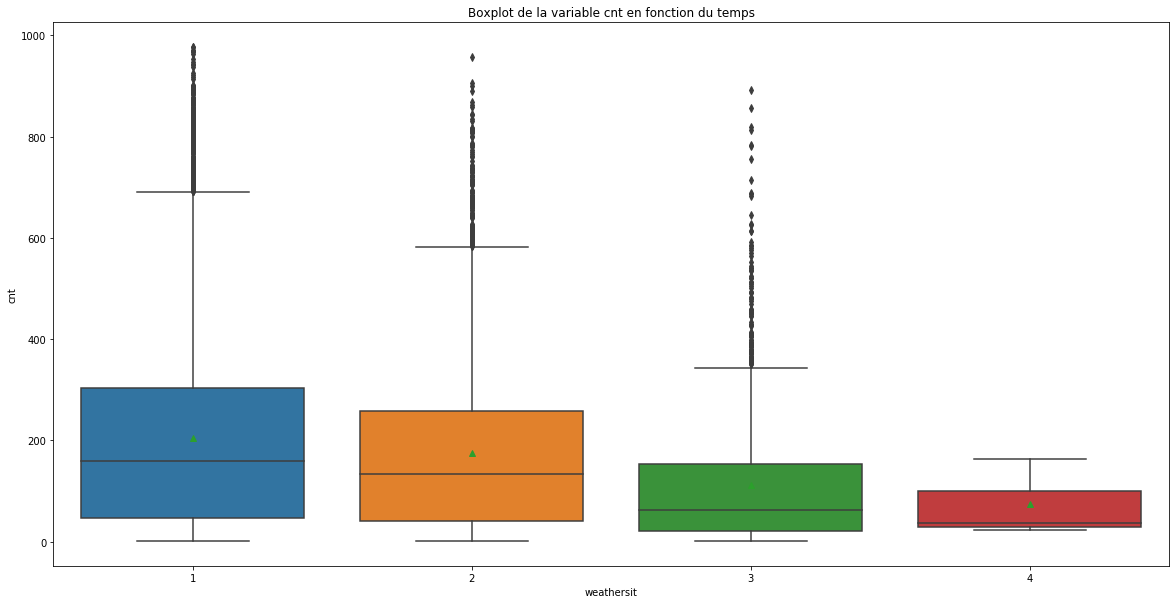

In [8]:
##########
## Boxplot de la variable cnt en fonction du temps
##########

plt.figure(figsize=(20,10))
sns.boxplot(x=data['weathersit'],y=data["cnt"],showmeans=True);
plt.title("Boxplot de la variable cnt en fonction du temps")
plt.show()

A partir des 2 boxplots ci-dessous, nous pouvons observer que les vacances et/ou les week-end ne semblent pas influencer la demande de vélo

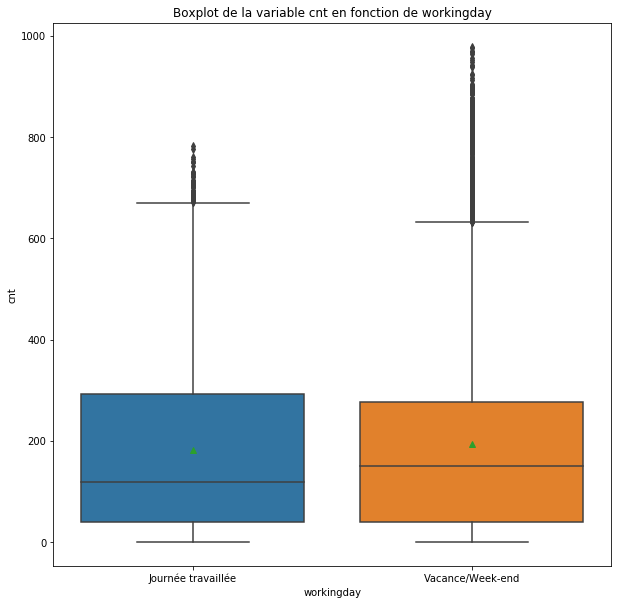

In [9]:
##########
## Boxplot de la variable cnt en fonction de workingday
##########


plt.figure(figsize=(10,10))
sns.boxplot(x=data['workingday'],y=data["cnt"],showmeans=True);
plt.title("Boxplot de la variable cnt en fonction de workingday")
plt.xticks([0, 1], ['Journée travaillée', 'Vacance/Week-end'])
plt.show()

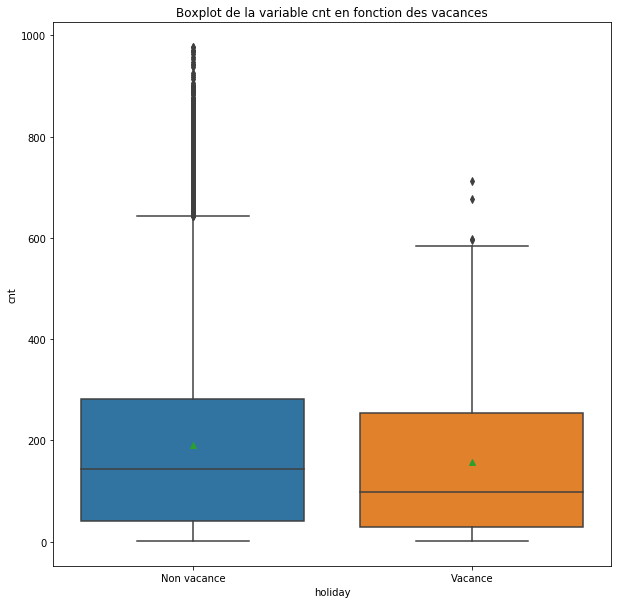

In [10]:
##########
## Boxplot de la variable cnt en fonction des vacances
##########

plt.figure(figsize=(10,10))
sns.boxplot(x=data['holiday'],y=data["cnt"],showmeans=True);
plt.title("Boxplot de la variable cnt en fonction des vacances")
plt.xticks([0, 1], ['Non vacance', 'Vacance'])
plt.show()

En regardant rapidement les boxplots de toutes les variables, nous pouvons constater que :
- les variables temp, atemp et hum sont assez symétriques
- la variable casual est encore plus asymétrique que la variable cnt

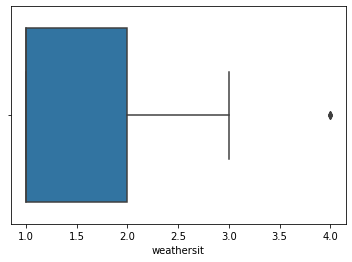

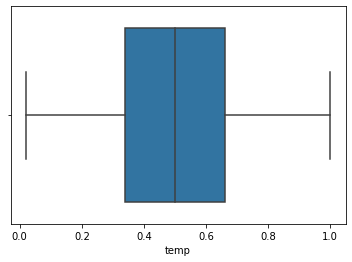

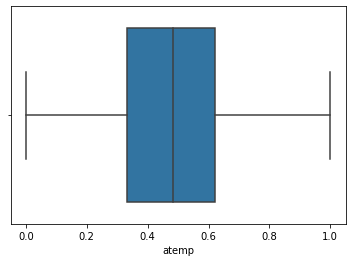

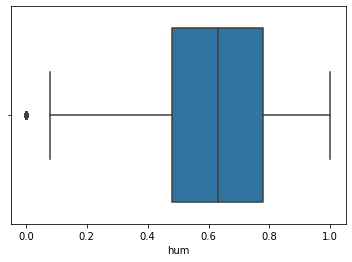

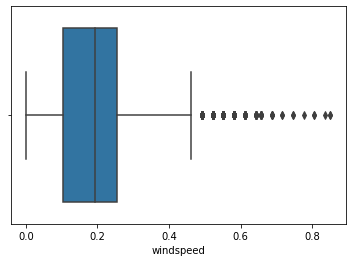

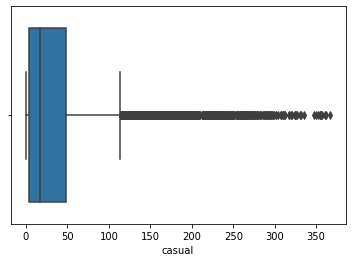

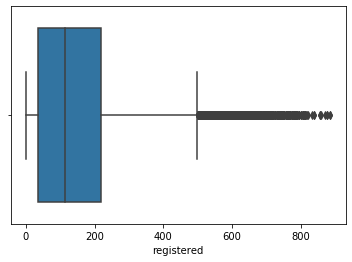

In [11]:
##########
## Boxplot de toute les variables quantitative qui ne sont pas cnt
##########

columns = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed','casual', 'registered']
for i, col in enumerate(columns):
    plt.figure(i)
    sns.boxplot(data[col])

Nous allons maintenant regarder l'évolution du nombre de vélos loués aux cours des deux années, nous remarquons une tendance positive et une possible saisonnalité.

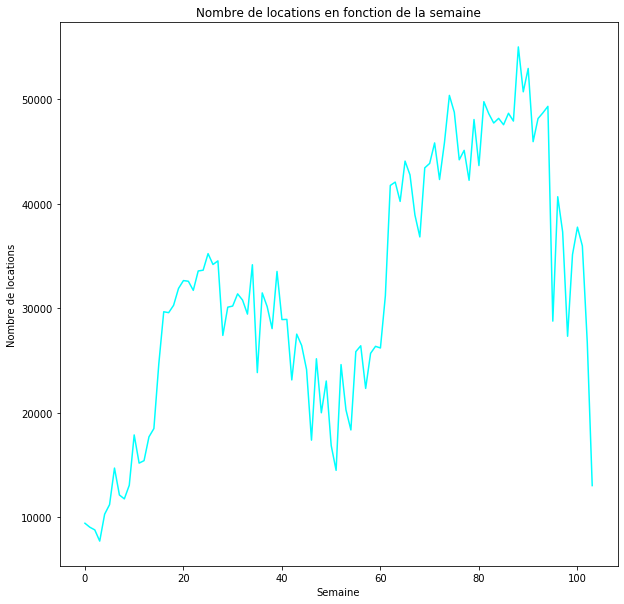

In [12]:
##########
## Plot du nombre de location en fonction de la semaine pour les 2 années
##########

plt.figure(figsize=(10,10))
mean_cnt = data.groupby(["yr",'week']).sum()["cnt"]
plt.plot(range(0,len(mean_cnt)),mean_cnt, color="aqua");
plt.title("Nombre de locations en fonction de la semaine")
plt.xlabel("Semaine")
plt.ylabel("Nombre de locations")
plt.show()

En regardant le nombre de vélos loués en fonction de la semaine, nous pouvons voir les tendances annuelles, des pics de locations entre mai et septembre et des baisses de locations entre  décembre et mars. Ce qui correspond assez bien à notre analyse en fonction des saisons effectuée ci-dessus. 

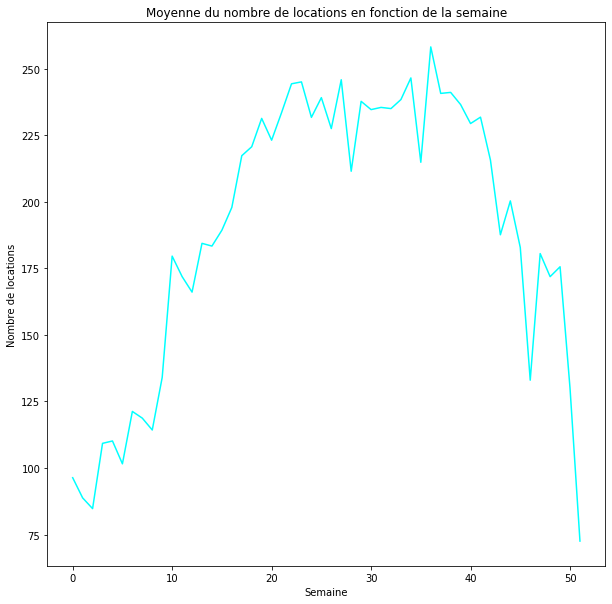

In [13]:
##########
## Plot de la moyenne du nombre de location en fonction de la semaine
##########


plt.figure(figsize=(10,10))
mean_cnt = data.groupby(["week"]).mean()["cnt"]
plt.plot(range(0,len(mean_cnt)),mean_cnt, color="aqua");
plt.title("Moyenne du nombre de locations en fonction de la semaine")
plt.xlabel("Semaine")
plt.ylabel("Nombre de locations")
plt.show()

Pour ce qui est de l'analyse en fonction de l'heure, il y a des pics de locations à 7h/8h et 17h/18h : des heures de début et de fin de journée de travail/école. Et pratiquement pas de locations entre 23h et 5h.

Text(0.5, 1.0, "Moyenne du nombre de locations en fonction de l'heure")

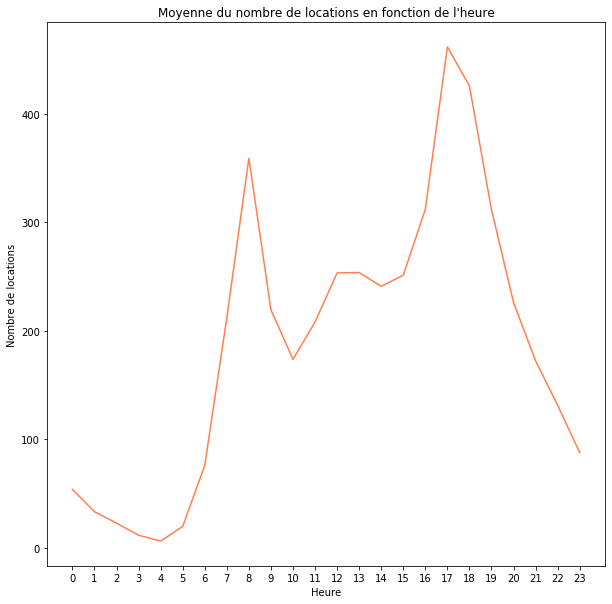

In [14]:
##########
## Plot de la moyenne du nombre de location en fonction de l'heure
##########


plt.figure(figsize=(10,10))
mean_cnt_hour = data.groupby(["hr"]).mean()["cnt"]
plt.plot(mean_cnt_hour.index,mean_cnt_hour,color="coral")
plt.xticks(mean_cnt_hour.index,mean_cnt_hour.index);
plt.xlabel("Heure")
plt.ylabel("Nombre de locations")
plt.title("Moyenne du nombre de locations en fonction de l'heure")

# Prédiction

Pour prédire la variable cnt nous allons utiliser un algorithme de gradient boosting provenant de la library lightgbm. Le gradient boosting est un algorithme assez puissant pour les problèmes de regressions de ce type. De plus la library lightgbm permet l'utilisation des variables catégorielles plus facilement.  
Comme critère de performance nous allons utiliser la moyenne absolue des erreurs pour permettre une interprétation plus simple et mieux gérer les outliers.  
L'étape de validation est réalisée en même temps que la construction du modèle de gradient boosting, elle permet de fixer le nombre d'arbres construits. Elle se fait en séparant la base en base d'apprentissage et base de test, la validation se fait bien entendu sur la base de test.  
Pour optimiser nos hyper-paramétres nous allons utiliser une optimisation bayésienne avec la library BayesianOptimization. Cette méthode est choisie principalement pour sa rapidité d'execution comparée aux autres méthodes d'optimisation(Grid Search, Random Search, ...).  
Pour effectuer notre prédiction :
- Nous enlevons les variables qui ne peuvent/doivent pas être exploités
- Nous splitons notre base en une base de test et une base d'apprentissage

In [15]:
Y = data["cnt"]
X = data.drop(columns = ["cnt","casual","registered","instant","dteday"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [16]:
categorical_features = ["season","workingday","holiday","weathersit","weekday"]
train_data = lgbm.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgbm.Dataset(X_test, label=y_test, reference=train_data)

## Optimisation Bayésienne des hyper-paramétres

In [17]:
##########
## Création d'une fonction calculant la fonction de perte de notre modèle en fonction des hyper-parametre
## que l'on cherche à optimiser
##########

def lgb_eval(num_leaves,max_depth,min_child_samples, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "regression",
        "metric" : "mae", 
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        "bagging_seed" : 0,
        "verbosity" : -1
    }
    categorical_features = ["season","workingday","holiday","weathersit","weekday"]
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       9999,
                       early_stopping_rounds=100,
                       stratified=False,
                       nfold=3)
    # On retourne l'opposé de la moyenne absolue des erreurs car l'on va chercher à maximiser un résultat 
    return -cv_result['l1-mean'][-1]

In [18]:
%%capture
##########
## Construction des ensembles de recherhe de nos paramétres
## Recherche du maximum de la fonction de perte des nos ensembles en utilisants un processus gaussien
##########

theta_bound={'num_leaves': (25, 4000),
             'max_depth': (1, 20),
             'min_child_samples': (50, 4000),
             'min_data_in_leaf': (100, 1000),
             'learning_rate':(0.01, 0.5)
            }

lgbBO = BayesianOptimization(lgb_eval,pbounds=theta_bound,random_state=0)

lgbBO.maximize(n_iter=100, init_points=10, random_state=0);
best_param = lgbBO.max['params']

In [19]:
best_param

{'learning_rate': 0.0773925818580082,
 'max_depth': 17.069735127276243,
 'min_child_samples': 3565.6093482626397,
 'min_data_in_leaf': 171.068971489607,
 'num_leaves': 3444.3376049007434}

In [20]:
##########
## Construction de l'aglorithme de gradient boosting avec les meilleurs paramètres
##########


params = {
        "objective" : "regression",
        "metric" : "mae", 
        "num_leaves" : int(best_param['num_leaves']),
        "max_depth" : int(best_param['max_depth']),
        "min_child_samples" : int(best_param['min_child_samples']),
        'min_data_in_leaf': int(best_param['min_data_in_leaf']),
        "learning_rate" : best_param['learning_rate'],
        "bagging_seed" : 0,
        "verbosity" : -1
    }
best_param = lgbBO.max['params']
gbm = lgbm.train(params,
                train_data,
                num_boost_round=9999,
                valid_sets=test_data,
                early_stopping_rounds=100,
                verbose_eval=400)

D:\Programme\Anaconda\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['holiday', 'season', 'weathersit', 'weekday', 'workingday']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[400]	valid_0's l1: 24.2427
[800]	valid_0's l1: 23.6678
Early stopping, best iteration is:
[1068]	valid_0's l1: 23.5679


Le graphique d'importance des variables de notre modèle nous indique que les variables les plus importantes sont des variables temporelles : hr, week et weekday. De manière surprenante la variable hum est la variable météorologique la plus importante dans le construction du modèle.

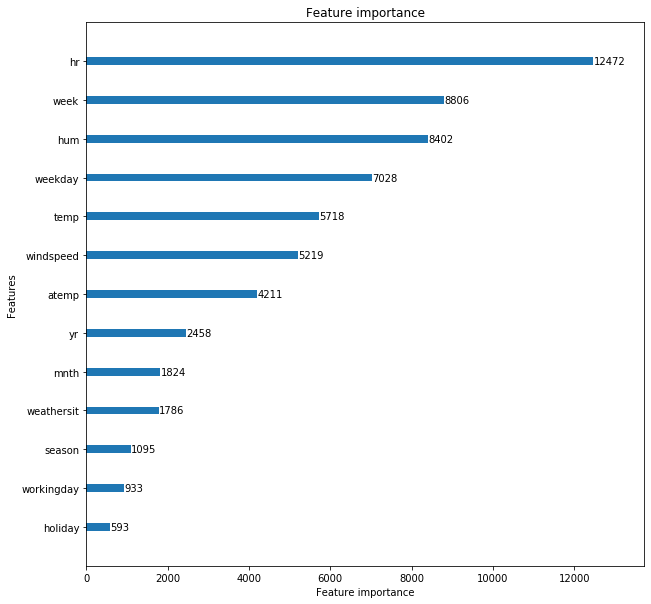

In [21]:
lgbm.plot_importance(gbm,grid=False,figsize=(10,10))

# Restitution

Nous avons pu, au cours de ce notebook analyser la base de données et construire un modèle de regression permettant d'estimer le nombre de locations de vélos en fonction du temps et de données météorologiques.  
Nous avons pu identifier que les saisons et la météo, principalement la température et l'humidité mais aussi la météo de manière plus globale (weathersit) avaient une impact sur le nombre de locations.  
De plus l'heure et la semaine ont elles aussi des impacts forts avec d'importantes fluctuations du nombre de locations en fonction de l'heure ou de la semaine observées.  
Enfin nous avons construit un algorithme de gradient boosting en optimisant les hyper-paramètres avec une optimisation Bayésienne. L'algorithme obtenu n'est pas parfait avec une erreur de 23.57 sur notre base de test mais il reste une bonne base pour prédire le nombre de locations qui seront effectuées à un moment donné.  
Pour ce qui est des pistes d'amélioration :
- pour la partie des statstiques descriptives : il serait intéressant d'effectuer des test (ANOVA, t-test ...), cependant le nombre d'observations ne permet pas facilement de les réaliser, il faudrait donc faire des échantillonnages mulitiples et agréger les résultats
- pour la partie prédiction : 
    - Regarder l'influence de l'évolution globale des demandes : nous avons remarquer sur nos graphiques que la demande semble être en croissance depuis deux ans, il est possible que les données de l'année 2011 ne soient pas pertinentes car le nombre de locations n'est plus vraiment comparable de 2011 à 2012
    - Construire un modèle composite c'est à dire construire un modèle par jour ou par saison, dont on agrege les resultats pour améliorer la précision globale.